In [2]:
import os
from pathlib import Path
from datasets import load_dataset
from transformers import ViTForImageClassification, ViTImageProcessor
from transformers import TrainingArguments, Trainer
import torch
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from datasets import DatasetDict

# Загрузка данных
dataset = load_dataset('imagefolder', data_dir='Z:\\Hakatons\\Welding\\output')

# Вывод структуры датасета
print(dataset)

# Вывод примера данных
print(dataset['train'][0])


Resolving data files:   0%|          | 0/3541 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3541
    })
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=43x57 at 0x2798F73A190>, 'label': 0}


In [2]:
import os
from pathlib import Path
from datasets import load_dataset
from transformers import ViTForImageClassification, ViTImageProcessor
from transformers import TrainingArguments, Trainer
import torch
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from datasets import DatasetDict


# Загрузка данных
dataset = load_dataset('imagefolder', data_dir='Z:\\Hakatons\\Welding\\output')

# Разделение датасета на обучающую и тестовую выборки
dataset = dataset['train'].train_test_split(test_size=0.2)  # 20% для тестирования

# Определение модели и токенизатора (image processor)
model_name = 'google/vit-base-patch16-224'
image_processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(dataset['train'].features['label'].names), ignore_mismatched_sizes=True)

# Определение трансформаций для изображений
normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = image_processor.size['height']  # Используем конкретное значение размера
_transforms = Compose([
    Resize((size, size)),  # Применяем Resize с корректными значениями
    CenterCrop(size),
    ToTensor(),  # Преобразуем изображение в тензор
    normalize,
])

def transform(example):
    """Функция для применения трансформаций к изображению"""
    if 'image' in example:
        example['pixel_values'] = _transforms(example['image'])
    return example

# Применяем трансформации к датасету
dataset = dataset.map(transform, batched=False)

# Создаем абсолютный путь для результатов
output_dir = Path('./results')
os.makedirs(output_dir, exist_ok=True)

# Определение параметров обучения
training_args = TrainingArguments(
    output_dir=str(output_dir),  # Директория для сохранения модели и других результатов
    evaluation_strategy="epoch",  # Изменено на eval_strategy
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir=str(output_dir / 'logs'),  # Директория для логов
    report_to="none",  # Отключаем TensorBoard
)

# Определение Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],  # Используем тестовую часть после разделения
    tokenizer=image_processor,
    data_collator=lambda data: {
        'pixel_values': torch.stack([torch.tensor(f['pixel_values']) for f in data]),  # Преобразуем элементы в тензоры
        'labels': torch.tensor([f['label'] for f in data])
    }
)

# Обучение модели
trainer.train()


Resolving data files:   0%|          | 0/3541 [00:00<?, ?it/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2832 [00:00<?, ? examples/s]

Map:   0%|          | 0/709 [00:00<?, ? examples/s]

C:\Users\aleks\anaconda3\envs\tf\lib\site-packages\transformers\models\vit\modeling_vit.py:253: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  context_layer = torch.nn.functional.scaled_dot_product_attention(


Epoch,Training Loss,Validation Loss
1,No log,0.084113
2,No log,0.053414
3,0.134000,0.046147


TrainOutput(global_step=531, training_loss=0.12629318748041285, metrics={'train_runtime': 1262.5697, 'train_samples_per_second': 6.729, 'train_steps_per_second': 0.421, 'total_flos': 6.583896461040353e+17, 'train_loss': 0.12629318748041285, 'epoch': 3.0})

Evaluation results: {'eval_loss': 0.046146973967552185, 'eval_runtime': 80.207, 'eval_samples_per_second': 8.84, 'eval_steps_per_second': 0.561, 'epoch': 3.0}
Accuracy: 0.9901269393511989
Precision: 0.9902704221319298
Recall: 0.9901269393511989
F1-Score: 0.9901075415593387


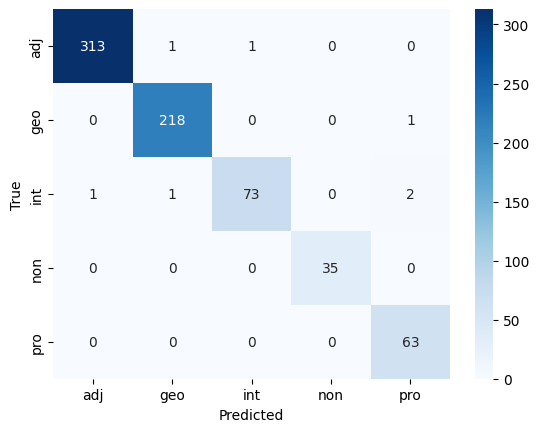

In [3]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Оценка модели
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

# Выполнение предсказаний
predictions, labels, _ = trainer.predict(dataset['test'])
predicted_labels = predictions.argmax(axis=1)

# Вычисление метрик
accuracy = accuracy_score(labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Для анализа предсказаний можно использовать confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset['test'].features['label'].names, yticklabels=dataset['test'].features['label'].names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [16]:
from PIL import Image
import torch
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from transformers import ViTForImageClassification, ViTImageProcessor

# Функция загрузки изображения
def load_image(image_path):
    return Image.open(image_path)

# Функция предобработки изображения
def preprocess_image(image, image_processor):
    transforms = Compose([
        Resize((image_processor.size['height'], image_processor.size['width'])),
        CenterCrop(image_processor.size['height']),
        ToTensor(),
        Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
    ])
    return transforms(image)

# Загрузка модели и процессора изображений из локальной директории
output_dir = Path('./results/checkpoint-500')
model = ViTForImageClassification.from_pretrained(output_dir)
image_processor = ViTImageProcessor.from_pretrained(output_dir)

# Классификация изображения
def classify_image(image_path):
    image = load_image(image_path)
    image = preprocess_image(image, image_processor)
    image = image.unsqueeze(0)  # Добавляем batch dimension

    model.eval()
    with torch.no_grad():
        outputs = model(image)
        logits = outputs.logits
        predicted_class_idx = logits.argmax(-1).item()

    return dataset['train'].features['label'].names[predicted_class_idx]



# Пример использования
image_path = 'Z:\\Hakatons\\Welding\\test\\12.jpg'
predicted_class = classify_image(image_path)
print(f"Predicted class: {predicted_class}")


Predicted class: non
